In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt

# ======================================================
# 1. LOAD FASHION-MNIST (10 classes gốc)
# ======================================================
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test  = x_test.reshape(-1, 28, 28, 1) / 255.0
# chỉ lấy 1000 ảnh để demo nhanh
x_train, y_train = x_train[:10000], y_train[:10000]
x_test,  y_test  = x_test[:100],  y_test[:100]

print("Fashion-MNIST train:", x_train.shape, y_train.shape)
print("Fashion-MNIST test:", x_test.shape, y_test.shape)


# ======================================================
# 2. LOAD 3 LỚP CUSTOM TỪ FOLDER
# ======================================================

datagen = ImageDataGenerator(rescale=1./255)

custom_train = datagen.flow_from_directory(
    "DATA/custom_data/train",
    target_size=(28, 28),
    color_mode="grayscale",
    class_mode="sparse",
    batch_size=32,
    shuffle=True
)

custom_test = datagen.flow_from_directory(
    "DATA/custom_data/test",
    target_size=(28, 28),
    color_mode="grayscale",
    class_mode="sparse",
    batch_size=32,
    shuffle=False
)


# ---- Chuyển generator → numpy (để gộp với Fashion-MNIST)
def gen_to_numpy(gen):
    X, y = [], []
    for _ in range(len(gen)):
        batch_x, batch_y = next(gen)
        X.append(batch_x)
        y.append(batch_y)
    return np.vstack(X), np.hstack(y)


x_custom_train, y_custom_train = gen_to_numpy(custom_train)
x_custom_test,  y_custom_test  = gen_to_numpy(custom_test)

print("Custom train:", x_custom_train.shape, y_custom_train.shape)
print("Custom test:", x_custom_test.shape, y_custom_test.shape)


# ======================================================
# 3. GHÉP FASHION + CUSTOM
# ======================================================

x_train_full = np.concatenate([x_train, x_custom_train])
y_train_full = np.concatenate([y_train, y_custom_train + 10])
# Custom label +10 để tránh trùng 10 class gốc

x_test_full = np.concatenate([x_test, x_custom_test])
y_test_full = np.concatenate([y_test, y_custom_test + 10])

num_classes = 15

# One-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test_onehot  = tf.keras.utils.to_categorical(y_test_full, num_classes)

print("Tổng train:", x_train_full.shape)
print("Tổng test:", x_test_full.shape)


# ======================================================
# 4. XÂY MODEL ≥7 LAYER (CNN)
# ======================================================

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')   # Softmax 15 lớp
])

model.summary()

# ======================================================
# 5. COMPILE + TRAIN
# ======================================================

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train_full, y_train_onehot,
    batch_size=64,
    epochs=20,
    validation_split=0.1
)


# ======================================================
# 6. ĐÁNH GIÁ
# ======================================================

test_loss, test_acc = model.evaluate(x_test_full, y_test_onehot)
print("\n🎉 Test accuracy:", test_acc)


# ======================================================
# 7. LƯU MODEL
# ======================================================

# model.save("fashion_15class_model.h5")
print("Model saved!")


Fashion-MNIST train: (10000, 28, 28, 1) (10000,)
Fashion-MNIST test: (100, 28, 28, 1) (100,)
Found 60 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Custom train: (60, 28, 28, 1) (60,)
Custom test: (15, 28, 28, 1) (15,)
Tổng train: (10060, 28, 28, 1)
Tổng test: (115, 28, 28, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,247 (1.26 MB)

 Trainable params: 331,247 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.6552 - loss: 0.9457 - val_accuracy: 0.7416 - val_loss: 1.1399
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.7932 - loss: 0.5427 - val_accuracy: 0.7644 - val_loss: 1.0595
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8350 - loss: 0.4468 - val_accuracy: 0.7863 - val_loss: 1.1852
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.8524 - loss: 0.3993 - val_accuracy: 0.8022 - val_loss: 1.1426
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8708 - loss: 0.3481 - val_accuracy: 0.8161 - val_loss: 1.1401
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.8801 - loss: 0.3156 - val_accuracy: 0.8151 - val_loss: 1.1634
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.8911 - loss: 0.2905 - val_accuracy: 0.8121 - val_loss: 1.2732
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9010 - loss: 0.2658 - val_a

Fashion-MNIST: (15000, 28, 28, 1) (15000,)
Found 100 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
Custom classes: ['hat', 'hoodie', 'scarf', 'socks', 'vest']
Custom train: (100, 28, 28, 1) (100,)
Tất cả 15 lớp: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'hat', 'hoodie', 'scarf', 'socks', 'vest']


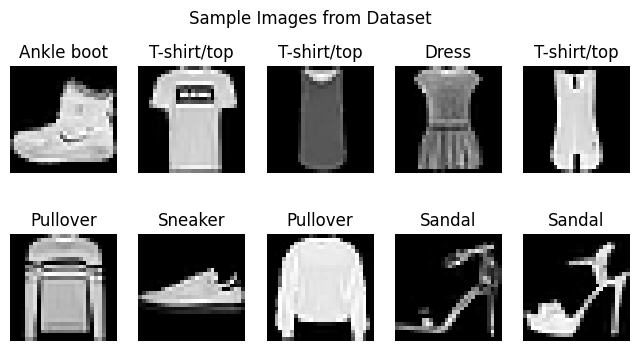

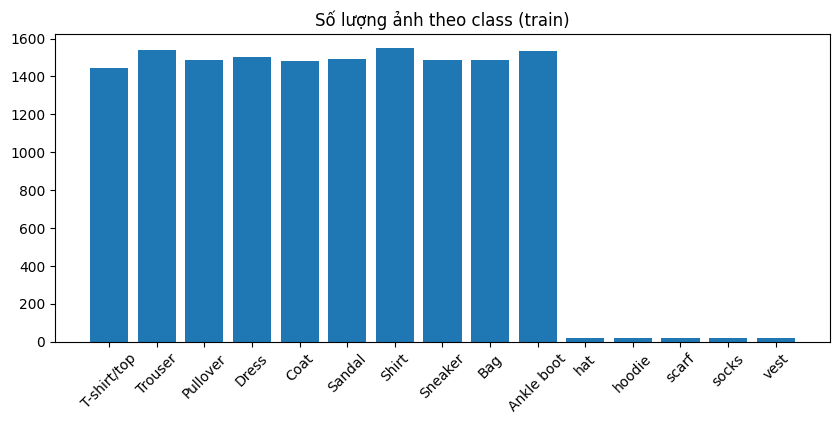

D:\school\se1_year4\IntSys\tieu_luan\code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,247 (1.26 MB)

 Trainable params: 331,247 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.7102 - loss: 0.8059 - val_accuracy: 0.7649 - val_loss: 1.1813
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.8162 - loss: 0.4930 - val_accuracy: 0.7887 - val_loss: 1.1633
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.8536 - loss: 0.4053 - val_accuracy: 0.7921 - val_loss: 1.0728
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.8681 - loss: 0.3564 - val_accuracy: 0.8179 - val_loss: 1.0489
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.8826 - loss: 0.3214 - val_accuracy: 0.8093 - val_loss: 0.9982
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.8918 - loss: 0.2889 - val_accuracy: 0.8205 - val_loss: 1.1617
Epoch 7/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.8998 - loss: 0.2653 - val_accuracy: 0.8291 - val_loss: 1.1691
Epoch 8/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9086 - loss: 0.2473 - 

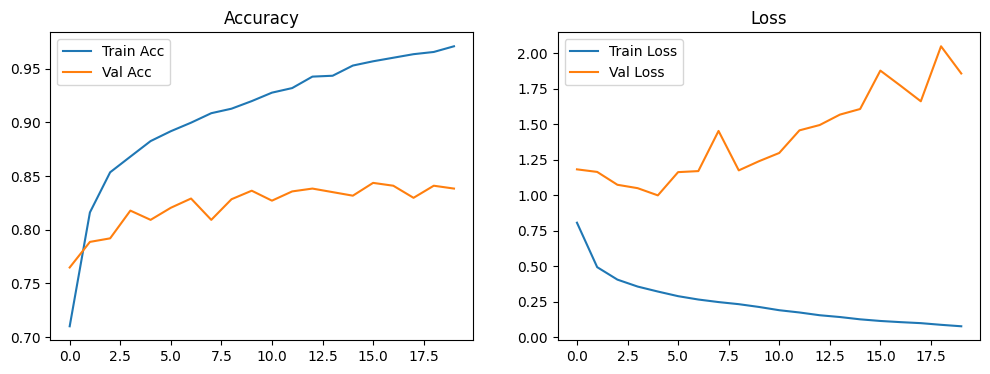

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8702 - loss: 1.0591

🎉 Test Accuracy: 0.8702439069747925


In [12]:
# ======================================================
# IMPORTS
# ======================================================
# Nguyễn Việt Quang B22DCCN650
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# ======================================================
# 1. LOAD FASHION-MNIST (10 classes gốc)
# Nguyễn Việt Quang B22DCCN650
# ======================================================
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test  = x_test.reshape(-1, 28, 28, 1) / 255.0

# chỉ lấy 10000 ảnh để demo nhanh
x_train, y_train = x_train[:15000], y_train[:15000]
x_test,  y_test  = x_test[:1000],  y_test[:1000]

fashion_classes = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

print("Fashion-MNIST:", x_train.shape, y_train.shape)


# ======================================================
# 2. LOAD CUSTOM DATA (5 lớp)
# Nguyễn Việt Quang B22DCCN650
# ======================================================
datagen = ImageDataGenerator(rescale=1./255)

custom_train = datagen.flow_from_directory(
    "DATA/custom_data/train",
    target_size=(28,28),
    color_mode="grayscale",
    class_mode="sparse",
    batch_size=32,
    shuffle=True
)

custom_test = datagen.flow_from_directory(
    "DATA/custom_data/test",
    target_size=(28,28),
    color_mode="grayscale",
    class_mode="sparse",
    batch_size=32,
    shuffle=False
)

custom_classes = list(custom_train.class_indices.keys())
print("Custom classes:", custom_classes)


# ======================================================
# 3. CONVERT GENERATOR → NUMPY (FIXED)
# Nguễn Việt Quang B22DCCN650
# ======================================================
def gen_to_numpy(gen):
    X, Y = [], []
    for batch_x, batch_y in gen:
        X.append(batch_x)
        Y.append(batch_y)
        if len(X) == len(gen):   # đủ số batch
            break
    return np.vstack(X), np.hstack(Y)

x_custom_train, y_custom_train = gen_to_numpy(custom_train)
x_custom_test,  y_custom_test  = gen_to_numpy(custom_test)

print("Custom train:", x_custom_train.shape, y_custom_train.shape)


# ======================================================
# 4. GỘP 10 lớp Fashion + 5 lớp Custom = 15 lớp
# Nguyễn Việt Quang B22DCCN650
# ======================================================
y_custom_train = y_custom_train.astype(int) + 10
y_custom_test  = y_custom_test.astype(int) + 10

x_train_full = np.concatenate([x_train, x_custom_train])
y_train_full = np.concatenate([y_train, y_custom_train])

x_test_full = np.concatenate([x_test, x_custom_test])
y_test_full = np.concatenate([y_test, y_custom_test])

num_classes = 15

y_train_onehot = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test_onehot  = tf.keras.utils.to_categorical(y_test_full, num_classes)

all_classes = fashion_classes + custom_classes
print("Tất cả 15 lớp:", all_classes)


# ======================================================
# 5. KHAI PHÁ DỮ LIỆU (EDA)
# Nguyễn Việt Quang B22DCCN650
# ======================================================

# ----- 5.1 Hiển thị 10 ảnh mẫu -----
plt.figure(figsize=(8,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train_full[i].reshape(28,28), cmap='gray')
    label = int(y_train_full[i])   # FIXED FLOAT → INT
    plt.title(all_classes[label])
    plt.axis('off')
plt.suptitle("Sample Images from Dataset")
plt.show()

# ----- 5.2 Phân bố số lượng ảnh theo class -----
plt.figure(figsize=(10,4))
unique, counts = np.unique(y_train_full.astype(int), return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, all_classes, rotation=45)
plt.title("Số lượng ảnh theo class (train)")
plt.show()


# ======================================================
# 6. XÂY MODEL ≥ 7 LỚP (CNN)
# Nguyễn Việt Quang B22DCCN650
# ======================================================
model = models.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes,activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# ======================================================
# 7. TRAIN MODEL
# Nguyễn Việt Quang B22DCCN650
# ======================================================
history = model.fit(
    x_train_full, y_train_onehot,
    validation_split=0.1,
    batch_size=64,
    epochs=20
)


# ======================================================
# 8. VISUALIZE ACCURACY / LOSS
# Nguyễn Việt Quang B22DCCN650
# ======================================================
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()


# ======================================================
# 9. EVALUATE
# Nguyễn Việt Quang B22DCCN650
# ======================================================
test_loss, test_acc = model.evaluate(x_test_full, y_test_onehot)
print("\n🎉 Test Accuracy:", test_acc)


# ======================================================
# 10. HÀM DỰ ĐOÁN ẢNH NGƯỜI DÙNG CHỌN
# ======================================================
def predict_image(path):
    img = Image.open(path).convert("L")
    img = img.resize((28,28))
    arr = np.array(img)/255.0
    arr = arr.reshape(1,28,28,1)

    pred = model.predict(arr)
    class_id = int(np.argmax(pred))

    plt.imshow(arr.reshape(28,28), cmap='gray')
    plt.title(f"Dự đoán: {all_classes[class_id]}")
    plt.axis('off')
    plt.show()

    print("🔵 Model dự đoán:", all_classes[class_id])

# Ví dụ:
# predict_image("any_image.jpg")

